In [154]:
from itertools import cycle


import numpy as np
import pandas as pd
from scipy import interp

import matplotlib.pyplot as plt
plt.style.use('dark_background')

%matplotlib inline

In [2]:
data = pd.read_csv('data/qaData.csv', parse_dates=['Date'])

In [3]:
data.head()

,Company,Participants,Date,EventName,EventType,AnalystName,AnalystCompany,Question,Answer,RegularTag1,RegularTag2,RegularTag3,EarningTag1,EarningTag2,EarningTag3
0,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,Glenn Schorr,Evercore ISI,"The performance in equities was great, and you...",There wasn’t anything particularly noteworthy ...,NIR,Markets,Equities,LOB,CIB,NaN
1,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,Glenn Schorr,Evercore ISI,You and others have been talking with your pri...,"Yes, this is where it would be. I wouldn’t say...",NIR,Markets,Prime brokerage / ROA,LOB,CIB,NaN
2,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,Glenn Schorr,Evercore ISI,In Jamie’s letter he talked about mentioning t...,"No, it is more of the same. Obviously, G-SIB t...",Regulatory Capital and Liquidity,GSIB,NaN,Firmwide,Capital,NaN
3,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,John McDonald,Sanford C. Bernstein & Co.,"On net interest income, do you have an outlook...","So again, assuming for a second that rates don...",NII / Balance Sheet,ALM / Rates / Duration,Rates,Firmwide,Balance sheet,NaN
4,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,Erika Najarian,Bank of America,"On CCAR, do you expect any potential surcharge...","Taking your first point, Erika, obviously, I d...",Regulatory Capital and Liquidity,GSIB,CCAR,Firmwide,Capital,NaN


In [4]:
data['Lag1'] = data.groupby(["Company", "Participants", "Date", "EventName", "EventType"])['EarningTag2'].shift(1)
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month

In [5]:
data.head()

,Company,Participants,Date,EventName,EventType,AnalystName,AnalystCompany,Question,Answer,RegularTag1,RegularTag2,RegularTag3,EarningTag1,EarningTag2,EarningTag3,Lag1,Year,Month
0,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,Glenn Schorr,Evercore ISI,"The performance in equities was great, and you...",There wasn’t anything particularly noteworthy ...,NIR,Markets,Equities,LOB,CIB,NaN,NaN,2015,4
1,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,Glenn Schorr,Evercore ISI,You and others have been talking with your pri...,"Yes, this is where it would be. I wouldn’t say...",NIR,Markets,Prime brokerage / ROA,LOB,CIB,NaN,CIB,2015,4
2,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,Glenn Schorr,Evercore ISI,In Jamie’s letter he talked about mentioning t...,"No, it is more of the same. Obviously, G-SIB t...",Regulatory Capital and Liquidity,GSIB,NaN,Firmwide,Capital,NaN,CIB,2015,4
3,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,John McDonald,Sanford C. Bernstein & Co.,"On net interest income, do you have an outlook...","So again, assuming for a second that rates don...",NII / Balance Sheet,ALM / Rates / Duration,Rates,Firmwide,Balance sheet,NaN,Capital,2015,4
4,JPMorgan Chase,"Jamie Dimon, Marianne Lake",2015-04-14,1Q15 earnings call,Earnings call,Erika Najarian,Bank of America,"On CCAR, do you expect any potential surcharge...","Taking your first point, Erika, obviously, I d...",Regulatory Capital and Liquidity,GSIB,CCAR,Firmwide,Capital,NaN,Balance sheet,2015,4


In [6]:
nn_data = data.loc[data['EventType']=="Earnings call", ['Company', 'Participants', 'Month', 'Year', 'AnalystName',	'AnalystCompany', 'EventName', 'Lag1', 'EarningTag2']].copy()
nn_data['Quarter'] = nn_data['EventName'].str.split("Q").str[0]
nn_data = nn_data[['Company', "Participants", "AnalystName", "AnalystCompany", "Month", "Year", "Quarter", "Lag1", "EarningTag2"]].copy()

In [7]:
nn_data.head()

,Company,Participants,AnalystName,AnalystCompany,Month,Year,Quarter,Lag1,EarningTag2
0,JPMorgan Chase,"Jamie Dimon, Marianne Lake",Glenn Schorr,Evercore ISI,4,2015,1,NaN,CIB
1,JPMorgan Chase,"Jamie Dimon, Marianne Lake",Glenn Schorr,Evercore ISI,4,2015,1,CIB,CIB
2,JPMorgan Chase,"Jamie Dimon, Marianne Lake",Glenn Schorr,Evercore ISI,4,2015,1,CIB,Capital
3,JPMorgan Chase,"Jamie Dimon, Marianne Lake",John McDonald,Sanford C. Bernstein & Co.,4,2015,1,Capital,Balance sheet
4,JPMorgan Chase,"Jamie Dimon, Marianne Lake",Erika Najarian,Bank of America,4,2015,1,Balance sheet,Capital


In [109]:
nn_data_encoded = pd.concat([nn_data, 
                             pd.get_dummies(nn_data['Company'], prefix='C', prefix_sep="_"),
                             pd.get_dummies(nn_data['Participants'], prefix='P', prefix_sep="_"),
                             pd.get_dummies(nn_data['AnalystName'], prefix='AN', prefix_sep="_"),
                             pd.get_dummies(nn_data['AnalystCompany'], prefix='AC', prefix_sep="_"),], axis=1)

new_cols = pd.get_dummies(nn_data['Company'], prefix='C', prefix_sep="_").columns.tolist() + \
             pd.get_dummies(nn_data['Participants'], prefix='P', prefix_sep="_").columns.tolist() + \
             pd.get_dummies(nn_data['AnalystName'], prefix='AN', prefix_sep="_").columns.tolist() + \
             pd.get_dummies(nn_data['AnalystCompany'], prefix='AC', prefix_sep="_").columns.tolist()

nn_data_encoded = nn_data_encoded[['Month', "Year", "Quarter", "Lag1", "EarningTag2"] + new_cols].copy()
new_cols = [col.replace(" ", "") for col in new_cols]
nn_data_encoded.columns = ['Month', "Year", "Quarter", "Lag1", "EarningTag2"] + new_cols

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, auc

X_train, X_test, y_train, y_test = train_test_split(X, y)

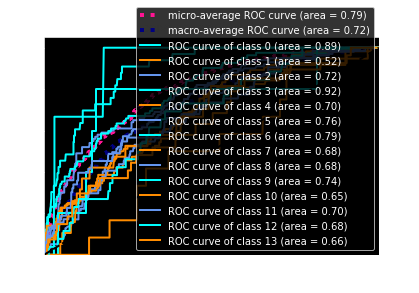

In [167]:
nn_data_encoded.dropna(inplace=True)
nn_data_encoded.reset_index(inplace=True, drop=True)
binarizer = LabelBinarizer().fit(nn_data_encoded['Lag1'])
lag = binarizer.transform(nn_data_encoded['Lag1'])
y = binarizer.transform(nn_data_encoded['EarningTag2'])

nn_data_binarized = nn_data_encoded.drop(['Lag1', 'EarningTag2'], axis=1)
X = pd.concat([nn_data_binarized, pd.DataFrame(lag)], axis=1)

classifier = OneVsRestClassifier(BernoulliNB())
y_score = classifier.fit(X_train, y_train).predict_proba(X_test)
n_classes = y_score.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.savefig('testFig')
plt.show()